In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cvxpy as cvx

# for CVXPY implementation
from solardatatools.clear_day_detection import find_clear_days as find_clear_days_cvx

# for OSD implementation
from solardatatools.osd_signal_decompositions import tl1_l2d2p365, l1_l2d2p365
from solardatatools.utilities import basic_outlier_filter

In [2]:
# Import data
fixtures_path = "/Users/smiskov/Documents/SLAC/PVInsight/solar-data-tools/tests/fixtures/"

data_file_path = Path(fixtures_path + "clear_day_detection/one_year_power_signals_1.csv")

with open(data_file_path) as file:
    data = np.loadtxt(file, delimiter=",")
expected_data_file_path = Path(fixtures_path + "clear_day_detection/one_year_weights_1.csv")

with open(expected_data_file_path) as file:
    expected_output = np.loadtxt(file, delimiter=",")
#expected_output = expected_output >= 1e-3

In [3]:
### CVXPY
cvx_actual_output = find_clear_days_cvx(data, boolean_out=False)
# Switched cvx.norm to cvx.sum_squares so now this assertion fails
np.testing.assert_array_almost_equal(expected_output, cvx_actual_output, 4)

AssertionError: 
Arrays are not almost equal to 4 decimals

Mismatched elements: 193 / 365 (52.9%)
Max absolute difference: 0.93432988
Max relative difference: 1.
 x: array([0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.898 ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.924 , 0.    , 0.905 ,
       0.9219, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.8864,...
 y: array([0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,...

In [4]:
### Define OSD function (reference right fn and update arg names, keeping c1 vals the same)

def filter_for_sparsity_osd(data, c1=1e3, solver="MOSEK"):
    daily_sparsity = np.sum(data > 0.005 * np.max(data), axis=0)
    
    ################################################################################################################
    filtered_signal = l1_l2d2p365(daily_sparsity, w2=c1, solver=solver)
    ################################################################################################################    
    
    mask = basic_outlier_filter(daily_sparsity - filtered_signal, outlier_constant=5.0)
    return mask

def find_clear_days_osd(
    data, smoothness_threshold=0.9, energy_threshold=0.8, boolean_out=True, solver="MOSEK"
):
    tc = np.linalg.norm(data[:-2] - 2 * data[1:-1] + data[2:], ord=1, axis=0)
    # Shift this metric so the median is at zero
    # tc = np.percentile(tc, 50) - tc
    # Normalize such that the maximum value is equal to one
    tc /= np.nanmax(tc)
    tc = 1 - tc
    # Seasonal renormalization: estimate a "baseline smoothness" based on local
    # 90th percentile of smoothness signal. This has the effect of increasing
    # the score of days if there aren't very many smooth days nearby
    
    ################################################################################################################
    y = tl1_l2d2p365(tc, tau=0.9, w2=1e3, yearly_periodic=False, solver='MOSEK')
    ################################################################################################################

    tc /= y
    # Take the positive part function, i.e. set the negative values to zero.
    # This is the first metric
    tc = np.clip(tc, 0, None)
    # Calculate the daily energy
    de = np.sum(data, axis=0)
    # Solve a convex minimization problem to roughly fit the local 90th
    # percentile of the data (quantile regression)
    
    ################################################################################################################
    x = tl1_l2d2p365(de, tau=0.9, w2=1e3, yearly_periodic=False, solver='MOSEK')
    ################################################################################################################

    # x gives us the local top 90th percentile of daily energy, i.e. the very sunny days. This gives us our
    # seasonal normalization.
    de = np.clip(np.divide(de, x), 0, 1)
    # Take geometric mean
    weights = np.multiply(np.power(tc, 0.5), np.power(de, 0.5))
    # Set values less than 0.6 to be equal to zero
    # weights[weights < 0.6] = 0.
    # Selection rule
    selection = np.logical_and(tc > smoothness_threshold, de > energy_threshold)
    weights[~selection] = 0.0
    # Apply filter for sparsity to catch data errors related to non-zero nighttime data
    msk = filter_for_sparsity_osd(data, solver=None)
    weights = weights * msk.astype(int)
    if boolean_out:
        return weights >= 1e-3
    else:
        return weights

In [13]:
### OSD
osd_actual_output = find_clear_days_osd(data, boolean_out=False)
np.testing.assert_array_almost_equal(cvx_actual_output, osd_actual_output, 2)

AssertionError: 
Arrays are not almost equal to 2 decimals

Mismatched elements: 23 / 365 (6.3%)
Max absolute difference: 0.90345005
Max relative difference: 1.
 x: array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.9 , 0.9 , 0.9 , 0.89, 0.  , 0.  , 0.  ,...
 y: array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.91, 0.91, 0.9 , 0.9 , 0.  , 0.  , 0.  ,...

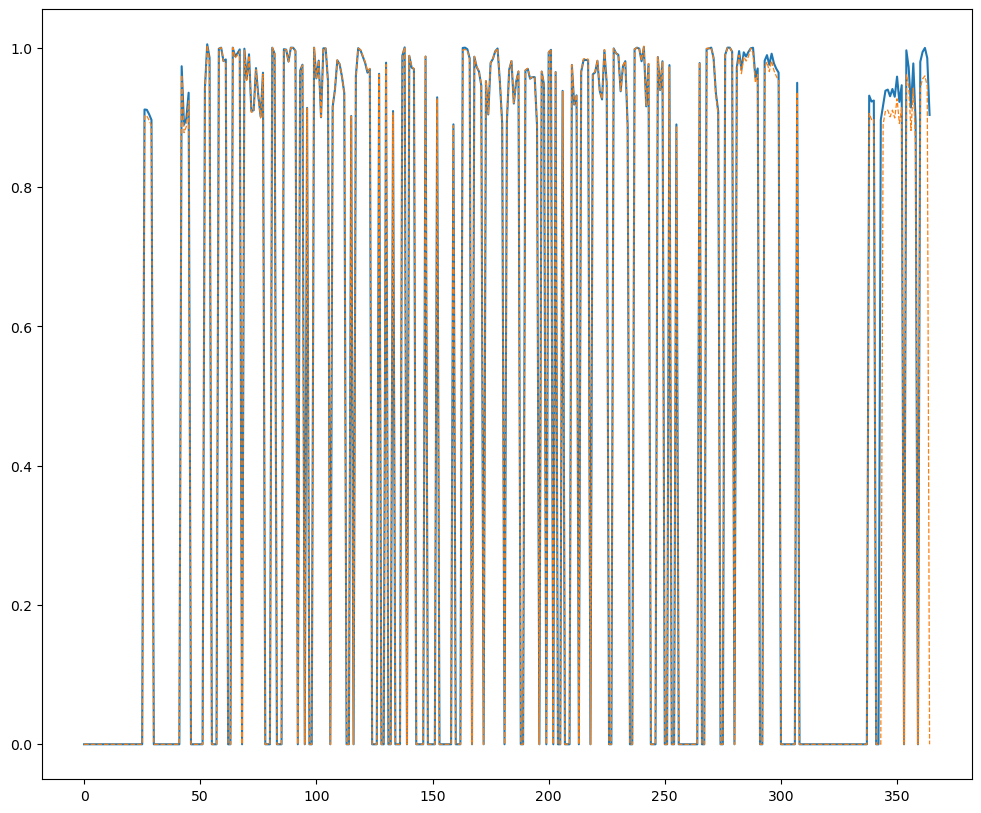

In [11]:
plt.figure(figsize=(12,10))
plt.plot(osd_actual_output)
plt.plot(cvx_actual_output, linewidth=0.9, linestyle="--")

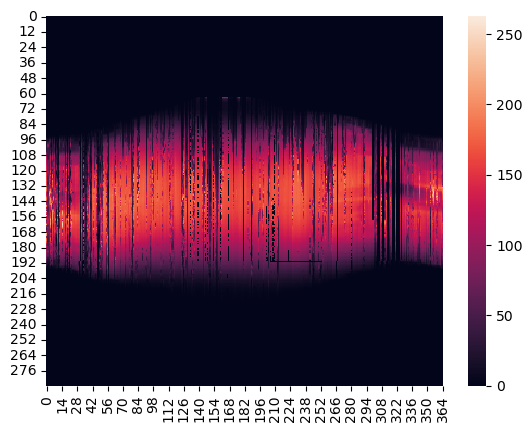

In [9]:
sns.heatmap(data);